# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-2nih0idm
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-2nih0idm


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


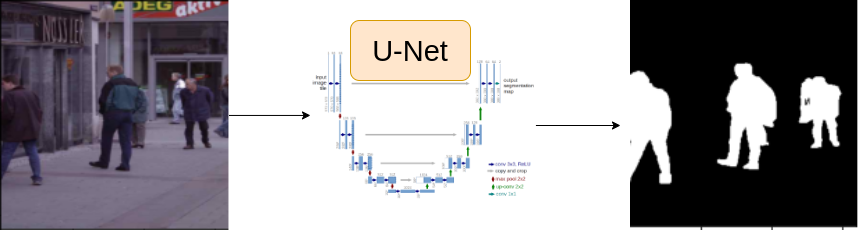

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 100
LR = 0.002
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]
image_path = row.images
masks_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(masks_path, cv2.IMREAD_GRAYSCALE) / 255.0

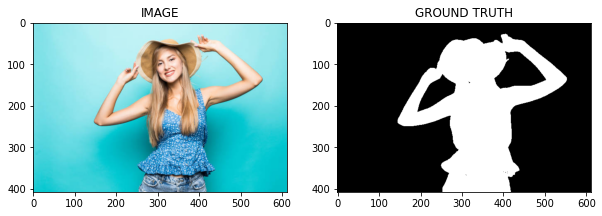

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
  ])

def get_val_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = df.iloc[idx]
    image_path = row.images
    masks_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(masks_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = np.expand_dims(mask, axis=-1) #h,w,c

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(float)
    mask = np.transpose(mask, (2,0,1)).astype(float)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask))

    return (image, mask)


In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_val_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


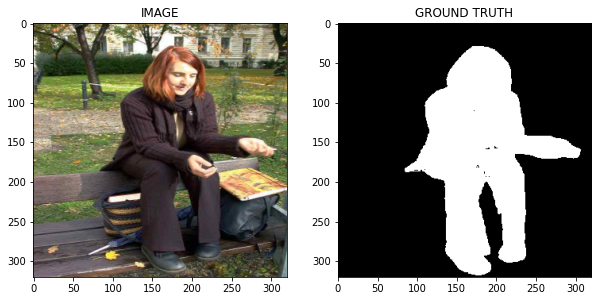

In [16]:
idx = 32

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')


total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None,
    )

  def forward(self, images, masks=None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)

      return logits, loss1+loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [24]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()

    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


In [25]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('Model Saved!')

  print(f'Epochs: {i} Train_loss: {train_loss} Validation_loss: {valid_loss}')



100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


Model Saved!
Epochs: 0 Train_loss: 0.7886747082074483 Validation_loss: 0.8049259185791016


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Model Saved!
Epochs: 1 Train_loss: 0.37726542750994363 Validation_loss: 0.4794612005352974


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Model Saved!
Epochs: 2 Train_loss: 0.27595261732737225 Validation_loss: 0.18008685484528542


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epochs: 3 Train_loss: 0.26048476894696554 Validation_loss: 0.25729280710220337


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Model Saved!
Epochs: 4 Train_loss: 0.2569284508625666 Validation_loss: 0.1506219357252121


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Model Saved!
Epochs: 5 Train_loss: 0.2079816887776057 Validation_loss: 0.1389381866902113


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Model Saved!
Epochs: 6 Train_loss: 0.1885690728823344 Validation_loss: 0.11197289638221264


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Model Saved!
Epochs: 7 Train_loss: 0.17423138121763865 Validation_loss: 0.10601995326578617


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 8 Train_loss: 0.17018932203451792 Validation_loss: 0.11704974621534348


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Model Saved!
Epochs: 9 Train_loss: 0.14518467287222545 Validation_loss: 0.1031736247241497


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Model Saved!
Epochs: 10 Train_loss: 0.14269839078187943 Validation_loss: 0.09473306685686111


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epochs: 11 Train_loss: 0.16079856157302858 Validation_loss: 0.10106093250215054


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Model Saved!
Epochs: 12 Train_loss: 0.14866212060054143 Validation_loss: 0.08934369497001171


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Model Saved!
Epochs: 13 Train_loss: 0.14645939419666926 Validation_loss: 0.0868727695196867


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Model Saved!
Epochs: 14 Train_loss: 0.11078434884548187 Validation_loss: 0.07447492703795433


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Model Saved!
Epochs: 15 Train_loss: 0.11215132971604665 Validation_loss: 0.07369356416165829


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Model Saved!
Epochs: 16 Train_loss: 0.09555508196353912 Validation_loss: 0.06982873566448689


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Model Saved!
Epochs: 17 Train_loss: 0.10339241996407508 Validation_loss: 0.06541567668318748


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Model Saved!
Epochs: 18 Train_loss: 0.08911391099294026 Validation_loss: 0.061836155131459236


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Epochs: 19 Train_loss: 0.10707127302885056 Validation_loss: 0.06995433755218983


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epochs: 20 Train_loss: 0.11920072933038076 Validation_loss: 0.07601718883961439


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Epochs: 21 Train_loss: 0.10507841060558955 Validation_loss: 0.06983904540538788


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 22 Train_loss: 0.11836202045281728 Validation_loss: 0.10727952979505062


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epochs: 23 Train_loss: 0.1208669771750768 Validation_loss: 0.08860333636403084


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 24 Train_loss: 0.10441961884498596 Validation_loss: 0.06624721083790064


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 25 Train_loss: 0.09132962723573049 Validation_loss: 0.06739537976682186


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Model Saved!
Epochs: 26 Train_loss: 0.08024507835507393 Validation_loss: 0.058501070365309715


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 27 Train_loss: 0.09117348293463388 Validation_loss: 0.06254356447607279


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 28 Train_loss: 0.0817779136200746 Validation_loss: 0.0629640482366085


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 29 Train_loss: 0.08320229798555374 Validation_loss: 0.06457243300974369


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Model Saved!
Epochs: 30 Train_loss: 0.08627317150433858 Validation_loss: 0.05806212592869997


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Model Saved!
Epochs: 31 Train_loss: 0.07308021709322929 Validation_loss: 0.053675465285778046


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Model Saved!
Epochs: 32 Train_loss: 0.07095452398061752 Validation_loss: 0.05184499453753233


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Model Saved!
Epochs: 33 Train_loss: 0.07064746742447217 Validation_loss: 0.05003193486481905


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Model Saved!
Epochs: 34 Train_loss: 0.06600926940639813 Validation_loss: 0.04733894392848015


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Epochs: 35 Train_loss: 0.0629342424372832 Validation_loss: 0.04830452334135771


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Epochs: 36 Train_loss: 0.06254718278845152 Validation_loss: 0.048549323342740536


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Model Saved!
Epochs: 37 Train_loss: 0.06433148657282194 Validation_loss: 0.043983377516269684


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epochs: 38 Train_loss: 0.06542251631617546 Validation_loss: 0.048499876633286476


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epochs: 39 Train_loss: 0.06569616968433062 Validation_loss: 0.04778337385505438


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 40 Train_loss: 0.06224132925271988 Validation_loss: 0.04616871569305658


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epochs: 41 Train_loss: 0.0577795813481013 Validation_loss: 0.04516533575952053


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Model Saved!
Epochs: 42 Train_loss: 0.055937579522530236 Validation_loss: 0.04261227883398533


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Model Saved!
Epochs: 43 Train_loss: 0.05252752403418223 Validation_loss: 0.04196356330066919


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Model Saved!
Epochs: 44 Train_loss: 0.05342645595471064 Validation_loss: 0.040192955173552036


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epochs: 45 Train_loss: 0.05355025356014569 Validation_loss: 0.042547025717794895


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epochs: 46 Train_loss: 0.05346619710326195 Validation_loss: 0.04244041349738836


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epochs: 47 Train_loss: 0.05416422535975774 Validation_loss: 0.04248166177421808


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epochs: 48 Train_loss: 0.05199268634120623 Validation_loss: 0.04145980067551136


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epochs: 49 Train_loss: 0.05220060994227727 Validation_loss: 0.04246936272829771


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Model Saved!
Epochs: 50 Train_loss: 0.056796241303284964 Validation_loss: 0.03995158802717924


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 51 Train_loss: 0.052620306611061096 Validation_loss: 0.041429960168898106


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Epochs: 52 Train_loss: 0.05368932783603668 Validation_loss: 0.04381674248725176


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epochs: 53 Train_loss: 0.08097887163360913 Validation_loss: 0.08712307456880808


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epochs: 54 Train_loss: 0.08368567079305649 Validation_loss: 0.0506712282076478


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 55 Train_loss: 0.16586329142252604 Validation_loss: 0.24302125722169876


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 56 Train_loss: 0.16486048797766367 Validation_loss: 0.08391318842768669


100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Epochs: 57 Train_loss: 0.1272470379869143 Validation_loss: 0.06286872550845146


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 58 Train_loss: 0.12263151804606119 Validation_loss: 0.11422064807265997


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 59 Train_loss: 0.11154682089885076 Validation_loss: 0.0686505576595664


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 60 Train_loss: 0.11037538001934687 Validation_loss: 0.057540830224752426


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 61 Train_loss: 0.09460557624697685 Validation_loss: 0.06032399274408817


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 62 Train_loss: 0.08821334739526113 Validation_loss: 0.0573617909103632


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epochs: 63 Train_loss: 0.07608972986539204 Validation_loss: 0.054503656923770905


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 64 Train_loss: 0.08011617908875147 Validation_loss: 0.0515599912032485


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 65 Train_loss: 0.06913030271728833 Validation_loss: 0.04615647345781326


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epochs: 66 Train_loss: 0.06192882160345713 Validation_loss: 0.043976761400699615


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 67 Train_loss: 0.05662366275986035 Validation_loss: 0.04210938885807991


100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


Epochs: 68 Train_loss: 0.05566446830828985 Validation_loss: 0.04101605759933591


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 69 Train_loss: 0.05327617029349009 Validation_loss: 0.041069055907428265


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Epochs: 70 Train_loss: 0.051536728938420616 Validation_loss: 0.04121030494570732


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Model Saved!
Epochs: 71 Train_loss: 0.05344488297899564 Validation_loss: 0.03957160469144583


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Model Saved!
Epochs: 72 Train_loss: 0.05055358683069547 Validation_loss: 0.039480336010456085


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Model Saved!
Epochs: 73 Train_loss: 0.04843247532844543 Validation_loss: 0.03802692424505949


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 74 Train_loss: 0.04963092878460884 Validation_loss: 0.039389955811202526


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epochs: 75 Train_loss: 0.04880165656407674 Validation_loss: 0.038951486349105835


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 76 Train_loss: 0.046836700787146884 Validation_loss: 0.04053856711834669


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 77 Train_loss: 0.04721970409154892 Validation_loss: 0.04027308011427522


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Model Saved!
Epochs: 78 Train_loss: 0.046800774584213896 Validation_loss: 0.03761393902823329


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Model Saved!
Epochs: 79 Train_loss: 0.045363583415746686 Validation_loss: 0.03746332414448261


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Model Saved!
Epochs: 80 Train_loss: 0.04482258036732674 Validation_loss: 0.03631062991917133


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Model Saved!
Epochs: 81 Train_loss: 0.04458981677889824 Validation_loss: 0.03600303549319506


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Model Saved!
Epochs: 82 Train_loss: 0.04519687021772067 Validation_loss: 0.035867970902472734


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Model Saved!
Epochs: 83 Train_loss: 0.047521426777044934 Validation_loss: 0.035338916815817356


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 84 Train_loss: 0.046839740375677744 Validation_loss: 0.0360686918720603


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Epochs: 85 Train_loss: 0.04511213997999827 Validation_loss: 0.0358187691308558


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epochs: 86 Train_loss: 0.04342191393176715 Validation_loss: 0.03628287464380264


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epochs: 87 Train_loss: 0.04263985976576805 Validation_loss: 0.03780265245586634


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Model Saved!
Epochs: 88 Train_loss: 0.04182966873049736 Validation_loss: 0.034803769551217556


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Model Saved!
Epochs: 89 Train_loss: 0.043154174586137135 Validation_loss: 0.03380125295370817


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epochs: 90 Train_loss: 0.04171015570561091 Validation_loss: 0.03513508103787899


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 91 Train_loss: 0.04262776623169581 Validation_loss: 0.035656655207276344


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Model Saved!
Epochs: 92 Train_loss: 0.0408320214599371 Validation_loss: 0.0331516033038497


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 93 Train_loss: 0.042349844922622046 Validation_loss: 0.03368004923686385


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epochs: 94 Train_loss: 0.04394537334640821 Validation_loss: 0.034540537279099226


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 95 Train_loss: 0.0611864926914374 Validation_loss: 0.05630981270223856


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epochs: 96 Train_loss: 0.06017799054582914 Validation_loss: 0.04239089135080576


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epochs: 97 Train_loss: 0.061139094084501265 Validation_loss: 0.04856187663972378


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 98 Train_loss: 0.09398831153909365 Validation_loss: 0.09508691355586052


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

Epochs: 99 Train_loss: 0.11434293140967687 Validation_loss: 0.055458527989685535


# Task 9 : Inference

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pt'))

In [32]:
idx = 11
image, mask = validset[idx]
logit_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logit_mask)
pred_mask = (pred_mask>0.5)*1.0

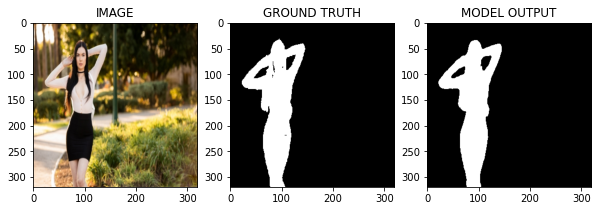

In [33]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya